# Домашнее задание №2

<span style="color: red; font-size: 14pt">Дедлайн: 13 марта 23:59</span>

Машинное обучение, ФИВТ, Весна 2018

Составлено с использованием материалов Евгения Колмакова и Юрия Кашницкого (открытый курс машинного обучения, тема 3), а также лекций по машинному обучению Евгения Соколова

**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2018_fall <номер_группы> <фамилия>``, к примеру -- ``ML2018_fall 596 ivanov``
- Выполненное дз сохраните в файл ``ML2018_<фамилия>_<группа>_task<номер задания>.ipnb``, к примеру -- ``ML2018_ivanov_596_task1.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2018_fall Question <Содержание вопроса>``

--------
- **PS1**: Используются автоматические фильтры, мы не найдем ваше дз, если вы укажете тему письма в неправильном формате.
- **PS2**: Просроченный дедлайн снижает максимальный вес задания по формуле, указнной на первом семинаре

In [28]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import pydotplus 

## Часть 0. Вопросы для самоконтроля

##### Перед выполнением задания убедитесь, что вы знаете ответы на этот теор.минимум
##### Эта часть задания не оценивается, ответы можно не записывать

1. Что такое решающее дерево? Как по построенному дереву найти прогноз для объекта?
2. Почему для любой выборки можно построить дерево, имеющее нулевую ошибку на ней? Приведите примеры.
3. Почему не рекомендуется строить небинарные деревья (имеющие более двух потомков у каждой вершины)?
4. Как устроен жадный алгоритм построения дерева?
5. Какие критерии информативности для решения задачи классификации вы знаете?
6. Какой смысл у критерия Джини и энтропийного критерия?
7. Какие критерии информативности для решения задачи регрессии вы знаете?
8. Что такое pruning (стрижка) дерева? Чем отличаются post-pruning и pre-pruning?
9. Какие методы обработки пропущенных значений вы знаете?
10. Как учитывать категориальные признаки в решающем дереве?
11. Что такое mean target encoding? Почему эта техника хорошо работает для решающих деревьев?
12. Как работает отбор признаков с помощью решающих деревьев?

## Часть 1. Теоретические задачи

##### 30% баллов за задание, оценочное время выполнения 1 час

##### Решение можно затехать здесь или написать от руки и добавить фото в ноутбук

### Задача 1 (10% баллов)

Какая стратегия поведения в листьях регрессионного дерева приводит к меньшему матожиданию ошибки по MSE: отвечать средним значением таргета на объектах обучающей выборки, попавших в лист, или отвечать таргетом для случайного объекта из листа (считая все объекты равновероятными)?

** Решение: **
$$
E(\frac{1}{n}\sum(y_i - \overline{y})^2) = \frac{1}{n}E(\sum(y_i^2 - 2 y_i \overline{y} + \overline{y}^2))
= \sum\frac{1}{n}(E(y_i^2) - 2 E(y_i \overline{y}) + E(\overline{y}^2))
= E(y_1^2) - 2 E(y_1 \overline{y}) + E(\overline{y}^2))
$$
Величины $y_i$ (прогнозируемые значения) и $\overline{y}$ (ответ алгоритма в этой вершине) независимы:
$$
(E(y_1^2) - 2 E(y_1 \overline{y}) + E(\overline{y}^2)) = 
(E(y_1^2) - 2 E(y_1) E(\overline{y}) + E(\overline{y}^2)) = 
(E(y_1^2) - E(y_1) E(\overline{y}) + E(\overline{y}^2) - E(y_1) E(\overline{y}))= 
$$
Если ответ алгоритма - случайный обьект из листа, то для него $E\overline{y_{rand}} = E(y)$. Если же ответ - среднее, то $E\overline{y_{mean}} =$$ E(\sum_{i=1}^{n} \frac{y_i^*}{n}) =$$ \frac{1}{n} n E(y^*) = E(y_1)$
Тогда:
$$
E(y_1^2) - E(y_1) E(y_1) + E(\overline{y}^2) - E(\overline{y}) E(\overline{y})= 
D(y_1) + D(\overline{y}) = L_{rand}
$$

Если выбирать случайный элемент из выборки, то его распределение такое же, как у $y_1$ и получаем:
$L = D(y_1) + D(y_1)$

Однако, дисперсия среднего в n раз меньше:
$$D(\overline{y_{mean}}) = E(\frac{1}{n}\sum y_i^* - E y_1)^2 = \frac{n}{n^2}E(y_2^2) + \frac{n(n-1)}{n^2} (E y_1)^2 - (E y_1)^2 =  \frac{1}{n}E(y_2^2) -\frac{1}{n} (E y_1)^2  = \frac{1}{n} D(y_1)$$
Т.е.$$ L_{mean} = D(y_1) + \frac{D(y_1)}{n} < L_{rand} $$ и луше отвечать среднее.

### Задача 2 (15% баллов)

Критерий информативности для набора объектов $L$ вычисляется на основе того, насколько хорошо их целевые переменные предсказываются константой (при оптимальном выборе этой константы):
$$H(R) = \min_{c \in Y} \dfrac{1}{|R|} \sum_{(x_i,y_i) \in R} L(y_i, c),$$
где $L(y_i, c)$- некоторая функция потерь. Соответственно, чтобы получить вид критерия при конкретной функции потерь, необходимо аналитически найти оптимальное значение константы и подставить его в формулу для $H(R)$.

Выведите критерии информативности для следующих функций потерь:
1. $L(y,c) = (y-c)^2$
2. $L(y,c) = \sum_{k=1}^K (c_k-[y=k])^2$
3. $L(y,c) = -\sum_{k=1}^K [y=k]\log c_k$

**Подсказка**:
должны получиться дисперия, критерий Джини и энтропийный критерий.

### 1. 
$$H(R) = \min_{c \in Y} \dfrac{1}{|R|} \sum_{(x_i,y_i) \in R} L_1(y_i, c)
= \min_{c \in Y} \dfrac{1}{|R|} \sum_{(x_i,y_i) \in R} (y_i - c) ^ 2 
$$

Известно, что эта функция имеет один минимум в среднем значении:

Возьмём производную от функции под минимум:
$$
2 \dfrac{1}{|R|} \sum_{(x_i,y_i) \in R} (y_i - c) = 0
\Rightarrow c = \sum_{(x_i,y_i) \in R} y_i = \overline{y}
$$

Итого:
$$H(R) = \min_{c \in Y} \dfrac{1}{|R|} \sum_{(x_i,y_i) \in R} (y_i - \overline{y}) ^ 2 
= \overline{(y - \overline{y})^2} 
$$ Получена выборочная дисперсия.

### 2.
$$H(R) = \min_{c \in Y} \dfrac{1}{|R|} \sum_{(x_i,y_i) \in R} L_3(y_i, c)
= \min_{c \in Y} \dfrac{1}{|R|} \sum_{(x_i,y_i) \in R}\sum_{k=1}^K (c_k-[y=k])^2
= \min_{c \in Y} \sum_{k=1}^K (c_k)^2 P(y = k) + (1 - c_k)^2 P(y \neq k)  \\
$$

Производная функции под минимумом по $c_k$:
$$
2(c_k) P(y = k) - 2(1 - c_k) P(y \neq k) = 0\\
c_k P(y = k) - (1 - c_k)(1 - P(y = k)) = 0 \\
c_k P(y = k) - 1 + c_k + P(y = k) - c_k P(y = k) = 0 \\
c_k = 1 - P(y = k) \\
$$
Функция есть сумма парабол, поэтому у неё хотя бы один минимум, который мы нашли.
Обратим внимание, что сумма c_k равна единице.
$$
\min_{c \in Y} \sum_{k=1}^K (c_k)^2 P(y = k) + (1 - c_k)^2 P(y \neq k)  \\
= \min_{c \in Y} \sum_{k=1}^K c_k^2 P(y = k) + 1 - 2 c_k + c_k^2 - P(y = k)  + 2 c_k P(y = k)  - c_k^2 P(y = k)  \\
= \sum_{k=1}^K 1 - 2 (1 - P(y = k)) + (1 - P(y = k))^2 - P(y = k)  + 2 (1 - P(y = k)) P(y = k) \\
= \sum_{k=1}^K 1 - 2 + 2P(y = k) + 1 - 2 P(y = k) + (P(y = k))^2 - P(y = k)  + 2 (1 - P(y = k)) P(y = k) \\
= \sum_{k=1}^K (P(y = k))^2 - P(y = k)  + 2 (1 - P(y = k)) P(y = k) \\
= \sum_{k=1}^K (P(y = k))^2 - P(y = k)  + 2 P(y = k)  - 2(P(y = k))^2 \\
= \sum_{k=1}^K P(y = k) - (P(y = k))^2 \\
= \sum_{k=1}^K P(y = k)(1 - P(y = k)) \\
$$

Получили критерий Джини

### 3.
$$H(R) = \min_{c \in Y} \dfrac{1}{|R|} \sum_{(x_i,y_i) \in R} L_3(y_i, c)
= \min_{c \in Y} \dfrac{1}{|R|} \sum_{(x_i,y_i) \in R}-\sum_{k=1}^K [y=k]\log c_k
= \min_{c \in Y} \dfrac{1}{|R|} \sum_{(x_i,y_i) \in R}-\sum_{k=1}^K [y=k]\log c_k \\
= \min_{c \in Y} - \sum_{k=1}^K P(y=k) \log c_k 
$$

В задании пропущено условие: $\sum_k=1^K c_k = 1$ (об этом писали в чате). Выразим $c_K = 1 - \sum_{k=1}^{K - 1} c_k$
Производная функции под минимумом по $c_k$:
$$
\frac{P(y=k)}{c_k} - \frac{P(y=K)}{1 - \sum_{k=1}^{K-1} c_k} = 0 \Rightarrow  \\
P(y=k) - P(y=k)\sum_{k=1}^{K-1} c_k  - P(y=K) с_k = 0 
$$

При подстановке $c_k = P(y = k)$ в левую часть получаем:
P(y=k) - P(y=k)\sum_{k=1}^{K-1} P(y = k) - P(y=K) P(y = k) = P(y=k) - P(y=k)P(y \neq K) - P(y=K) P(y = k) =
P(y=k) - P(y=k) (P(y \neq K) + P(y=K)) = P(y=k) - P(y=k) = 0.

Т.е. при данных с_k чатные производные равны нулю.
Получаем:

$$
H(R) = \min_{c \in Y} - \sum_{k=1}^K P(y=k) \log c_k =  - \sum_{k=1}^K P(y=k) \log P(y=k)
$$

Получен энтропийный критерий

### Задача 3 (5% баллов)

Запишите оценку сложности построения одного решающего дерева в зависимости от размера обучающей выборки $l$, числа признаков $d$, максимальной глубины дерева $D$. В качестве предикатов используются пороговые функции $[x_j>t]$. При выборе предиката в каждой вершине перебираются все признаки, а в качестве порогов рассматриваются величины $t$, равные значениям этого признака на объектах, попавших в текущую вершину. Считайте сложность вычисления критерия информативности константной.

** Комментарий: ** Если выбирать в качестве порогов не значения признаков, а послусуммы между уникальными значениями признаков (т.е для X = [1, 3, 4] не [1, 3, 4], а [(1+3)/2, (3+4)/2]), то в среднем итог на тестовой выборке будет лучше, в частности, это подтверждается на данных из этого ноутбука. 

Сложность вычисления критерия информативности - не константа! Если для фиксированного массива длины n она вычисляется за O(n), тогда сложность её вычисления суммарно за построение можно оценить сверху как $O(D l)$ (на каждом уровне дерева суммарно не больше $O(l)$ времени на вычисление критерия.

** Решение: ** Будем считать, что все признаки вещественные, а, значит, у каждого обьекта может быть различное значение этого признака. Тогда при выборе одного порога мы перебираем $O(ld_x)$ значений, где $d_x$ - число обьектов в этой вершине. 

Тогда на каждом уровне дерева для построения мы перебирали $O(l \sum d_i^l)$ = $O(ld)$, где $d_i^l$ - число обьектов в i-ой вершине уровня l. Ясно, что на каждом уровне число обьектов не меньше, чем их было в начале. (Замечание по обозначениям: $O(x) = O(y) \forall x <= y)

В итоге, получаем не более $O(Dld)$ на построение, при чём эта оценка достигается в случае, если дерево получается, например, полным бинарным. Итого с учётом вычисления критерия $O(Dld) + O(Dl) = O(Dld)$

## Часть 2. Визуализация решающих деревьев

##### 20% баллов за задание, оценочное время выполнения 30 минут

Для начала нужно поставить GraphViz

- На macOS:
    - sudo pip install pydotplus
    - brew install graphviz
- Linux должно работать то же самое с заменой brew на sudo apt-get
    - sudo pip install pydotplus
    - sudo apt-get install graphviz
- Windows
    - Установить GraphViz отсюда: http://www.graphviz.org/Download_windows.php
    - Добавить путь к папке bin в PATH (например, "C:\Programs\Graphviz2.38\bin")
    - pip install pydotplus

Постройте решающее дерево из sklearn на датасете Car Evaluation Dataset (https://archive.ics.uci.edu/ml/datasets/car+evaluation)

In [650]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.c45-names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.names

--2018-03-13 23:14:24--  https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.c45-names
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.249
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 276 [text/plain]
Сохранение в: «car.c45-names»

car.c45-names       100%[===================>]     276  --.-KB/s    за 0s      

2018-03-13 23:14:26 (6,26 MB/s) - «car.c45-names» сохранён [276/276]

--2018-03-13 23:14:26--  https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.249
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 51867 (51K) [text/plain]
Сохранение в: «car.data»

car.data            100%[===================>]  50,65K  65,7KB/s    за 0,8s    

2018-03-13 23:14

In [651]:
!cat car.c45-names

| names file (C4.5 format) for car evaluation domain

| class values

unacc, acc, good, vgood

| attributes

buying:   vhigh, high, med, low.
maint:    vhigh, high, med, low.
doors:    2, 3, 4, 5more.
persons:  2, 4, more.
lug_boot: small, med, big.
safety:   low, med, high.


In [652]:
df = pd.read_csv("car.data", header=None)
df.columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [653]:
df.tail()

,buying,maint,doors,persons,lug_boot,safety,class
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good
1727,low,low,5more,more,big,high,vgood


Признаков немного, перекодируем их как-нибудь осмысленно

In [654]:
mapper = {"vhigh":4, "high":3, "med":2, "low":1}
mapper_doors = {"2":2, "3":3, "4":4, "5more":5}
mapper_persons = {"2":2, "4":4, "more":6}
mapper_lb = {"small":1, "med":2, "big":3}
mapper_class = {"unacc":1, "acc":2, "good":3, "vgood":4}

def map_dataframe(df, mappers):
    for i, c in enumerate(df.columns):
        df[c] = np.array(list(map(lambda x: mappers[i][x], df[c].values)))
    return df

df_trans = df.copy()
map_dataframe(df_trans, [mapper, mapper, mapper_doors, mapper_persons, mapper_lb, mapper, mapper_class])
df_trans.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,4,4,2,2,1,1,1
1,4,4,2,2,1,2,1
2,4,4,2,2,1,3,1
3,4,4,2,2,2,1,1
4,4,4,2,2,2,2,1


In [655]:
X = df_trans[df_trans.columns[:-1]].values
y = df_trans[df_trans.columns[-1]].values

clf = DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Визуализируйте получившееся дерево с помощью GraphViz (следующая функция может помочь):

In [656]:
import IPython.display #needed to render in notebook
import StringIO, pydot  #needed to convert dot format to png

from sklearn import tree

def draw_decision_tree(clf, column_names):
    #dot_data = StringIO.StringIO() 
    dot_data = tree.export_graphviz(clf, out_file="small_tree.out",
                                    feature_names=column_names) 
    #graph = pydot.graph_from_dot_data(dot_data.getvalue())
    graph = pydotplus.graphviz.graph_from_dot_file("small_tree.out")  
    a = IPython.display.Image(graph.create_png())
    IPython.display.display(a)

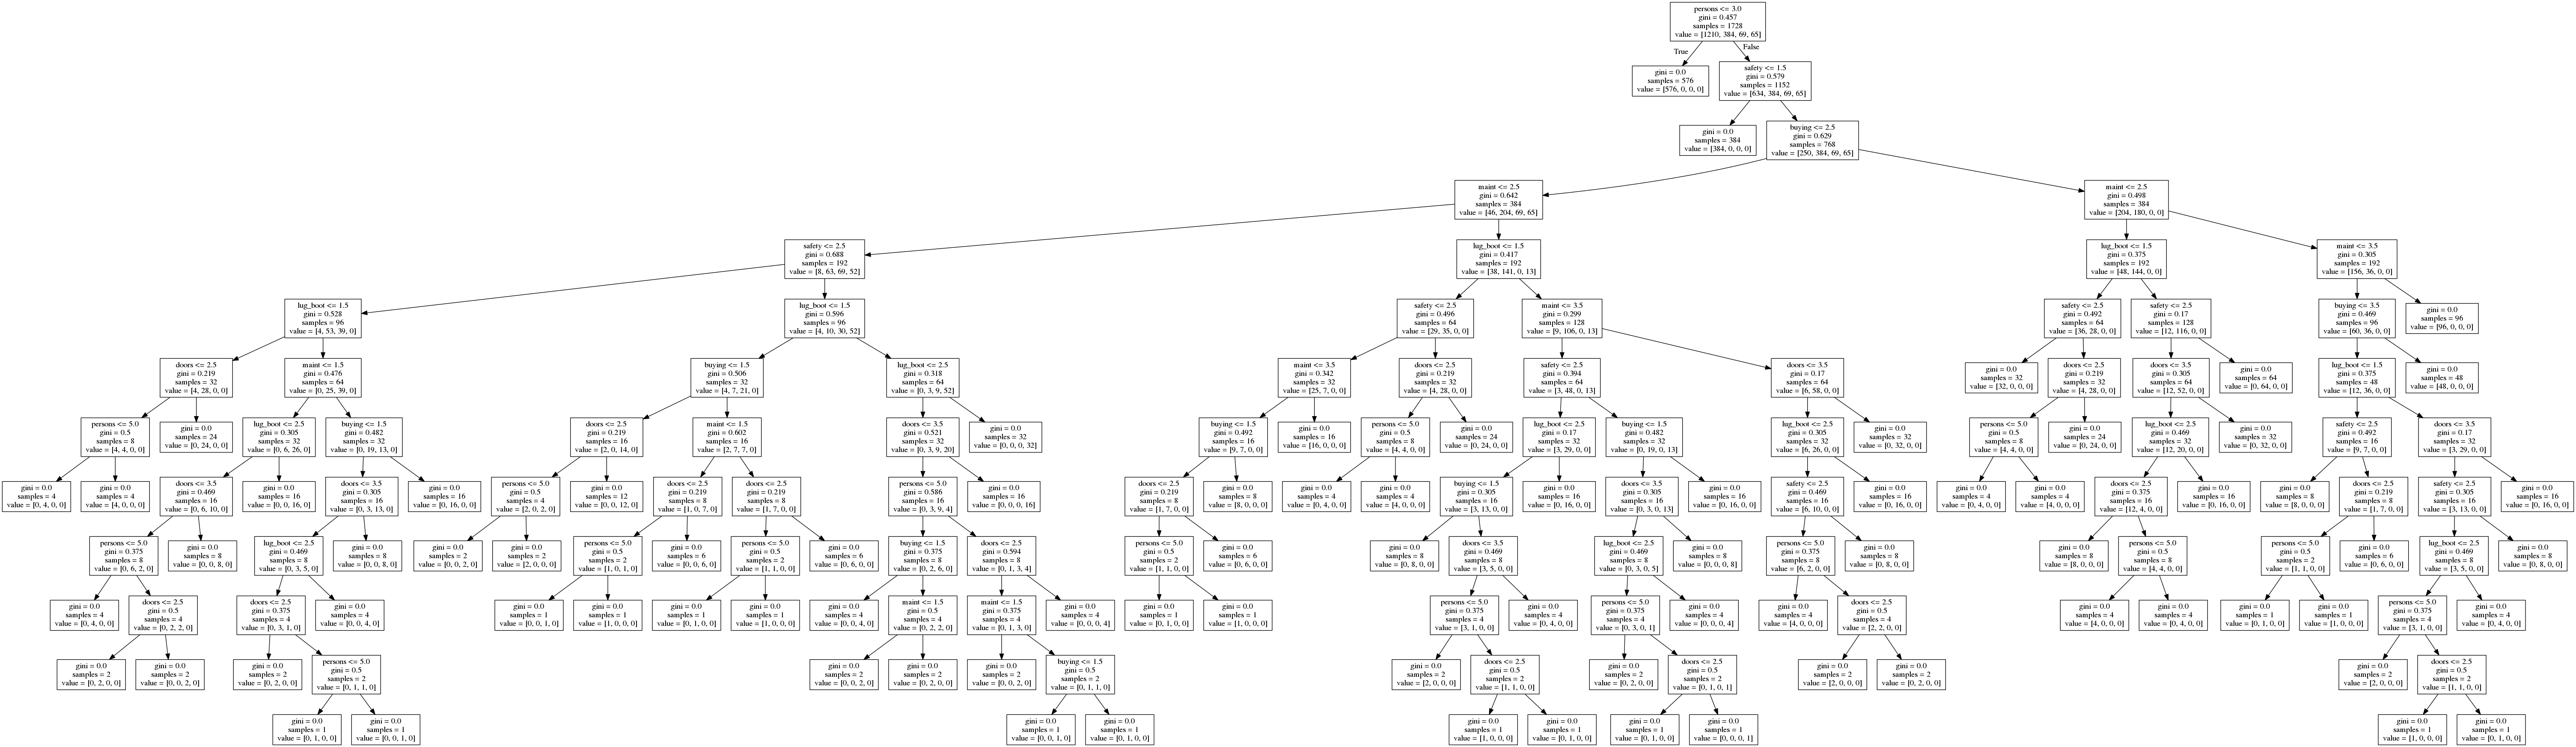

In [657]:
draw_decision_tree(clf, df_trans.columns[:-1])

Посмотрите, как меняется картинка для различных значений структурных параметров (варьируйте параметры max_depth, criterion, min_samples_leaf, max_features). Убедитесь, что увеличение глубины дерева и уменьшение количества объектов в листьях способствует гибкости модели и, как следствие, переобучению (что соответствует интуитивным соображениям о структуре дерева).

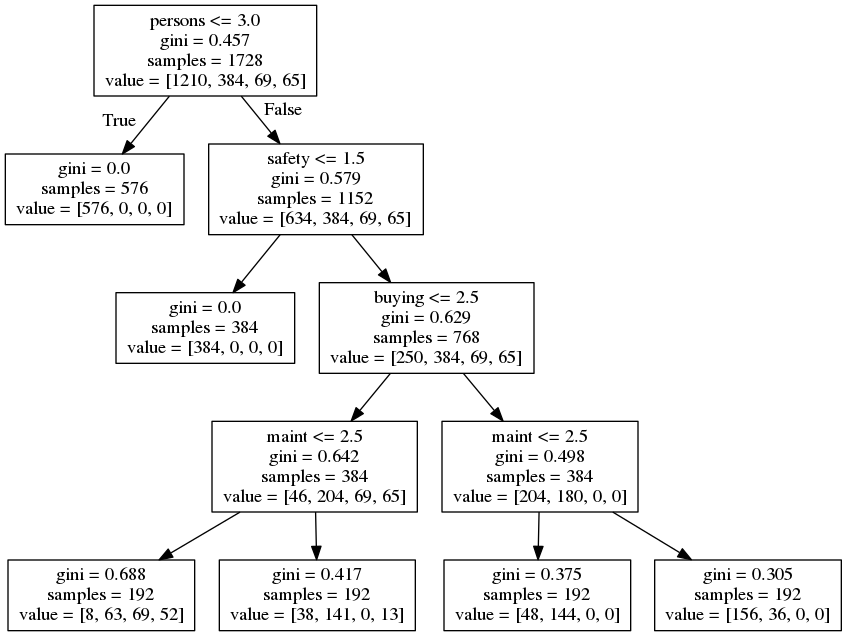

In [658]:
clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X, y)
draw_decision_tree(clf, df_trans.columns[:-1])

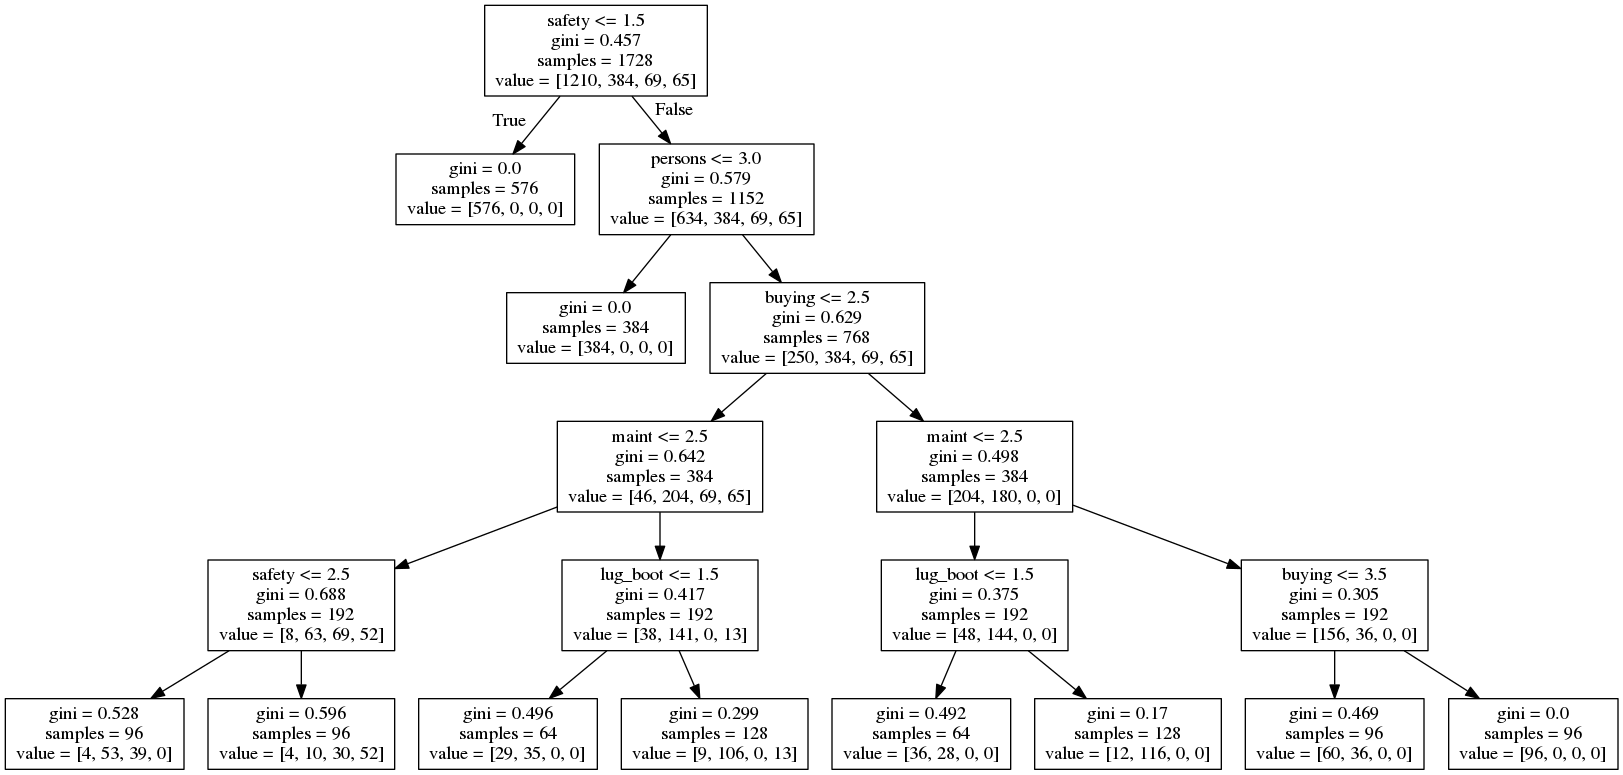

In [659]:
clf = DecisionTreeClassifier(max_depth=5)  # Запомним, что глубина - максимальное число верщин на пути от листа к корню
clf.fit(X, y)
draw_decision_tree(clf, df_trans.columns[:-1])

**Комментарий:** При увеличениии глубины появляется больше листов с малым числом обьектов в них, что и ожидалось, что и ведёт к переобучению

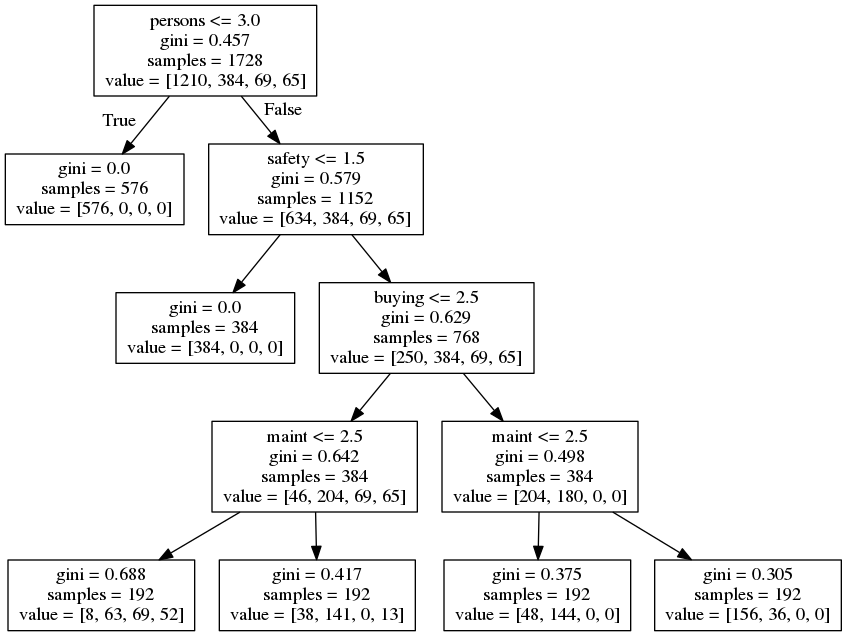

In [660]:
clf = DecisionTreeClassifier(min_samples_leaf= 100)
clf.fit(X, y)
draw_decision_tree(clf, df_trans.columns[:-1])

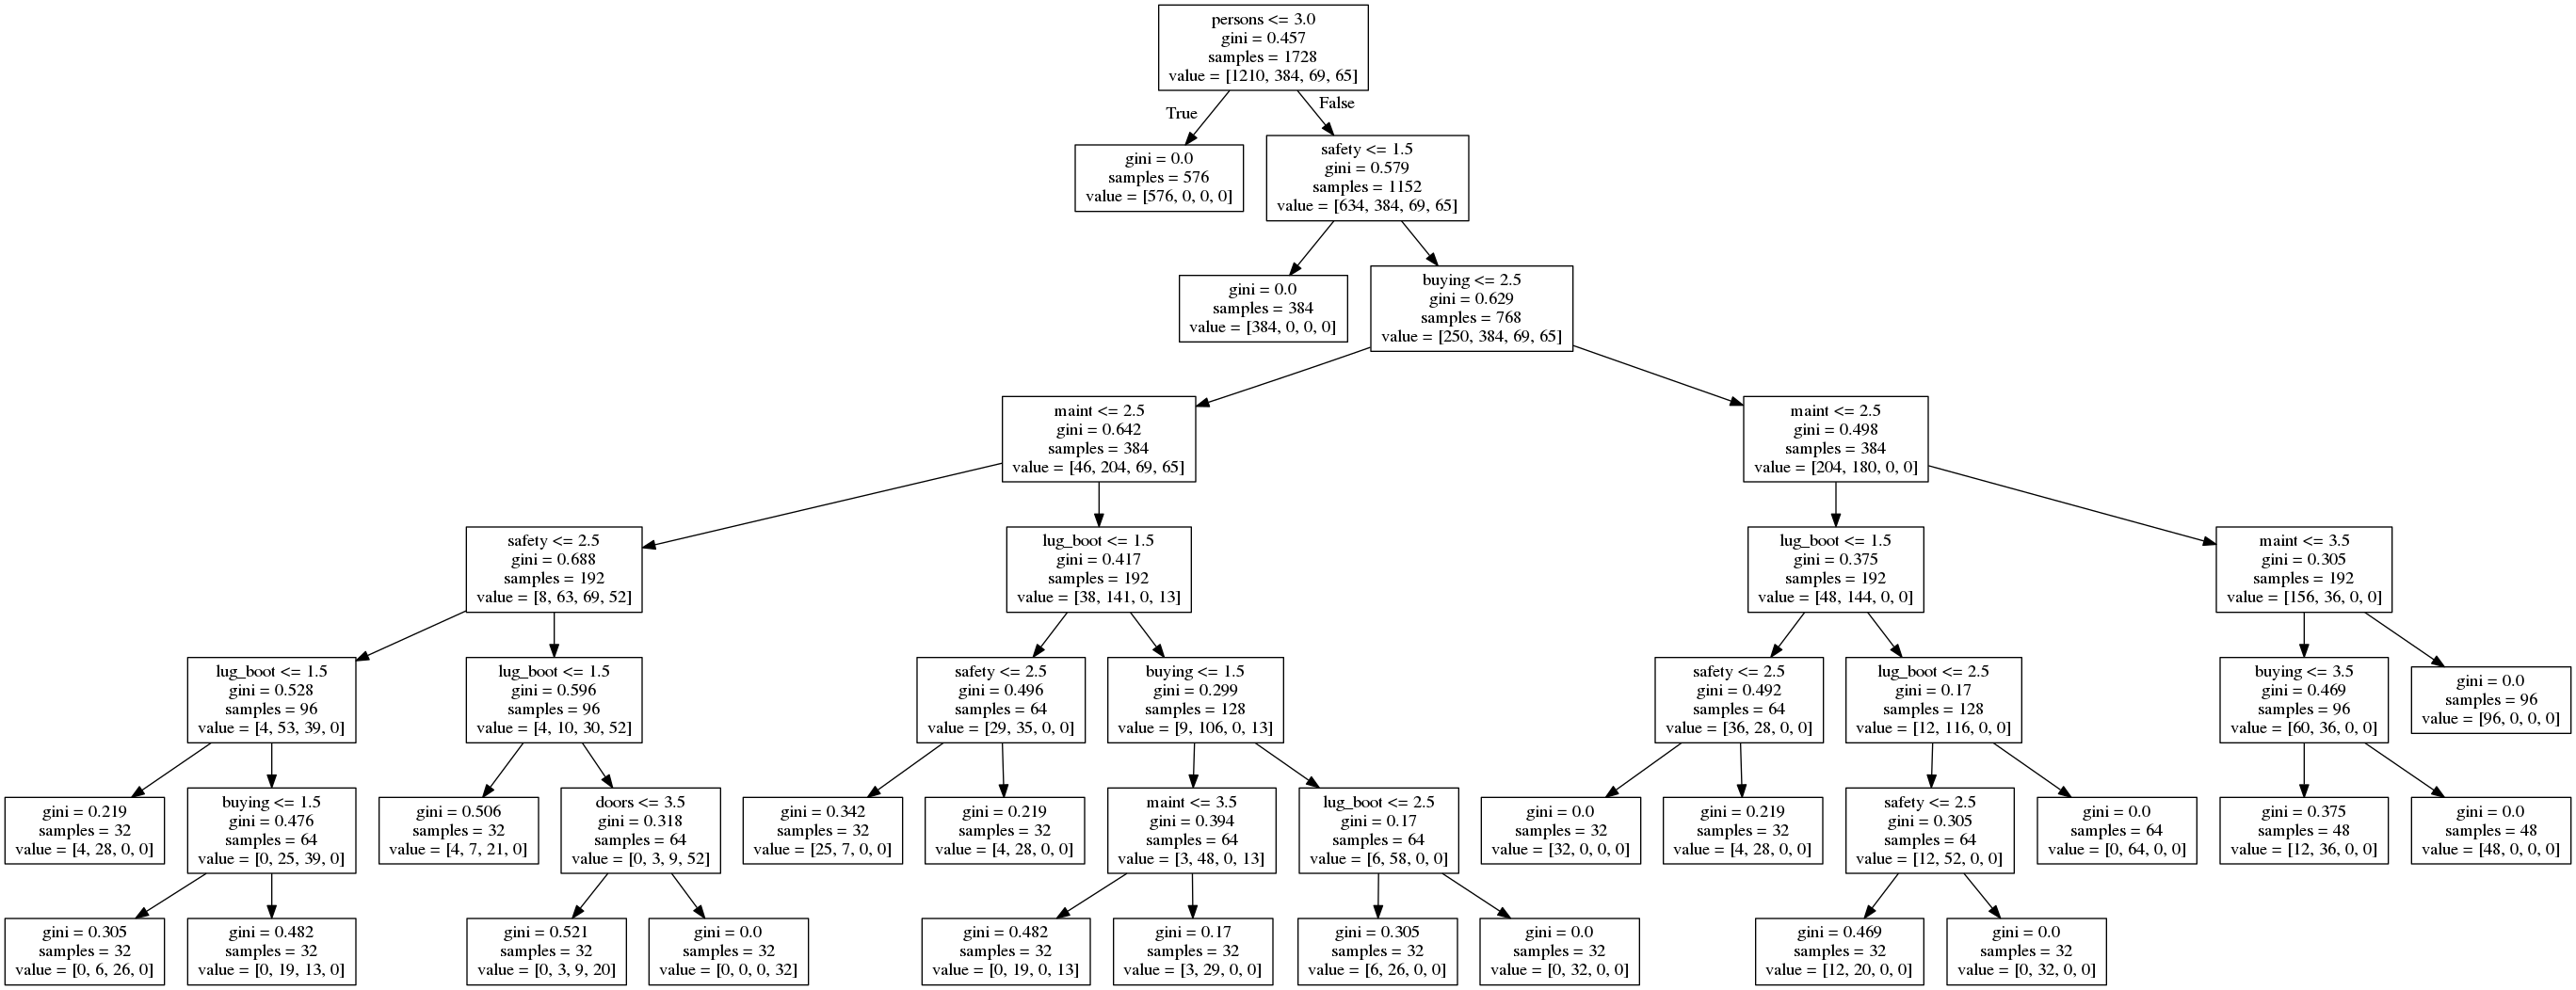

In [661]:
clf = DecisionTreeClassifier(min_samples_leaf=30)
clf.fit(X, y)
draw_decision_tree(clf, df_trans.columns[:-1])

**Комментарий:** то же самое, уменьшили число обьектов в листьях - увеличили глубину, начинаем переобучаться на выборке.

In [662]:
clf = DecisionTreeClassifier(max_features=1)
clf.fit(X, y)
draw_decision_tree(clf, df_trans.columns[:-1])

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.885906 to fit



**Комментарий:** ужас какой-то. Похоже, он расклассифицировал по одному признаку просто всю выборку, так что не стоит ожидать хорошего качества. C другой стороны, такое переобученное дерево неплохо бы смотрелось в случайном лесе.

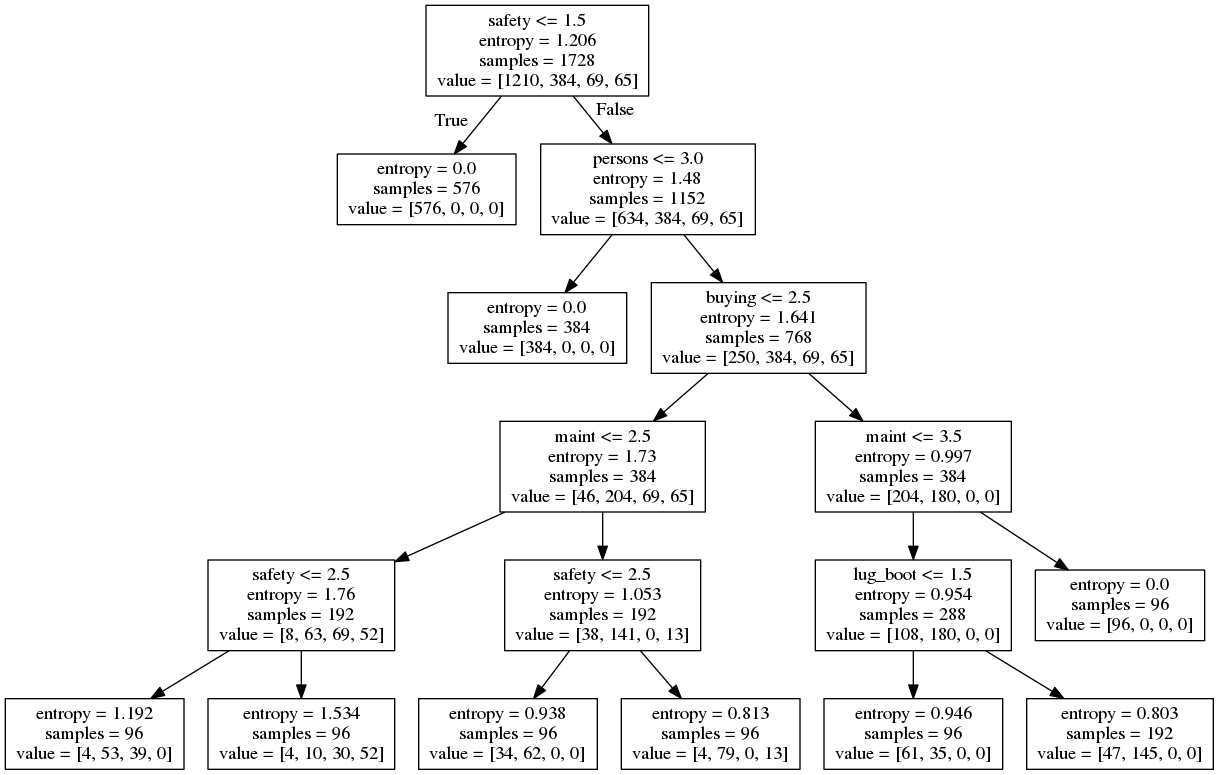

In [663]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)
clf.fit(X, y)
draw_decision_tree(clf, df_trans.columns[:-1])

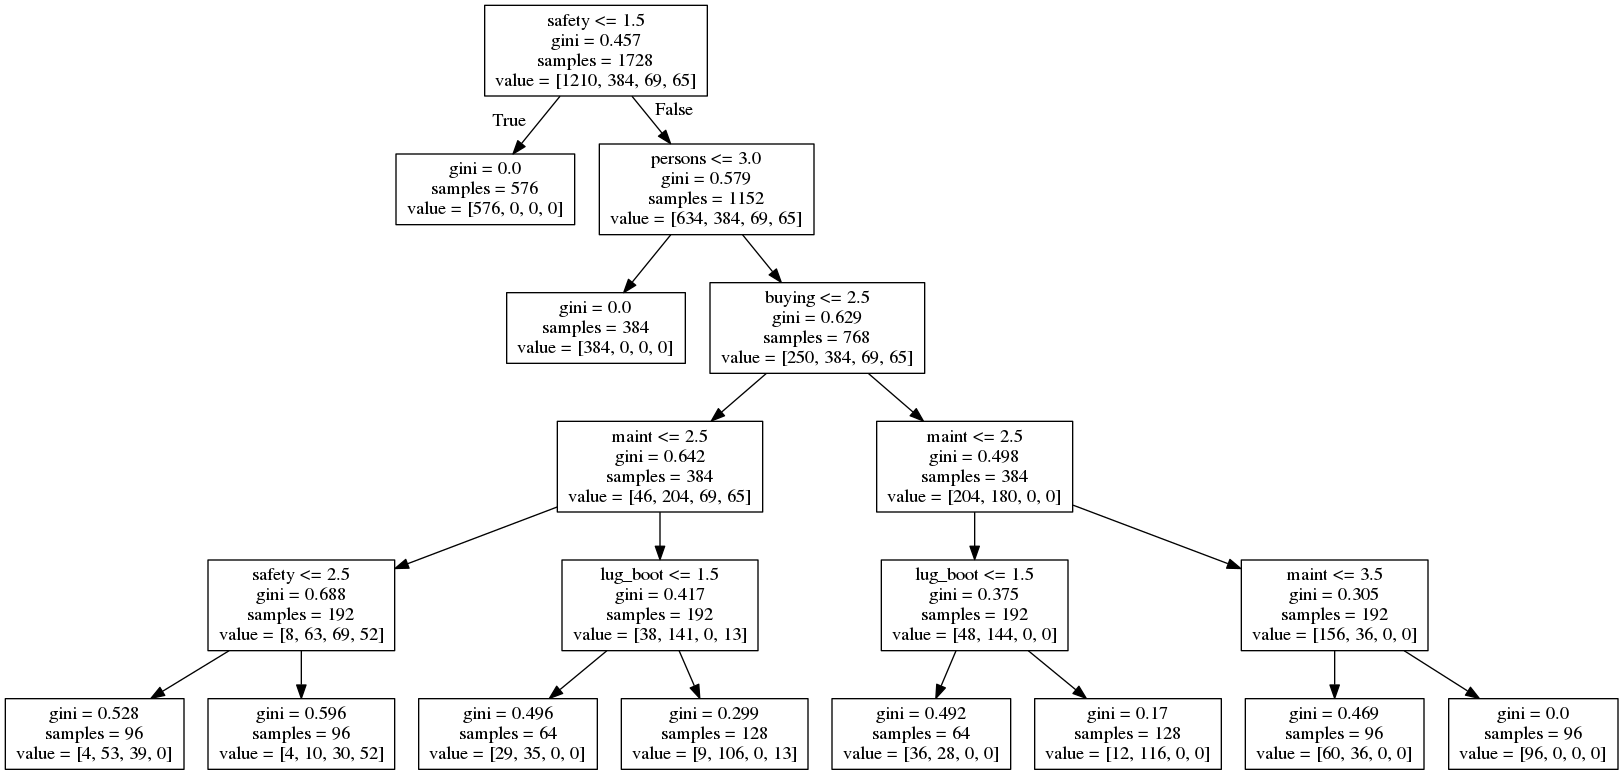

In [664]:
clf = DecisionTreeClassifier(criterion="gini", max_depth=5)
clf.fit(X, y)
draw_decision_tree(clf, df_trans.columns[:-1])

**Комментарий:** Хотя критерии разные,на первых четырёх уровнях деревья не отличаются.

## Часть 3. Реализация алгоритма построения дерева решений

##### 50% баллов за задание, оценочное время выполнения 2-3 часа

In [665]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from collections import Counter

Зафиксируем заранее `random_state` (a.k.a. random seed). Это должно повысить вероятность полной воспроизводимости результатов, впрочем, замечено, что тем не менее небольшие флуктуации возможны (например, качества прогнозов дерева, которое мы сейчас вырастим) в случае разных ОС.

In [666]:
RANDOM_STATE = 42

**Необходимо реализовать класс `DecisionTree`**

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    `max_depth` - максимальная глубина дерева (по умолчанию - `numpy.inf`); 
    `min_samples_split` - минимальное число объектов в вершине, при котором происходит её разбиение (по умолчанию - 2); 
    `criterion` - критерий разбиения (для классификации - 'gini' или 'entropy', для регрессии - 'variance' или 'mad_median'; 
    по умолчанию - 'gini');
    
    Функционал, значение которого максимизируется для поиска оптимального разбиения в данной вершине имеет вид
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    где $X$ - выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ - разбиение выборки $X$ на две части 
    по предикату $[x_j < t]$, а $F(X)$ -критерий разбиения.
    
    1. Для классификации: пусть $p_i$ - доля объектов $i$-го класса в выборке $X$.
    
        - 'gini': Неопределенность Джини $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
        - 'entropy': Энтропия $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
    2. Для регрессии: $y_j = y(x_j)$ - ответ на объекте $x_j$, $y = (y_1, \dots, y_{|X|})$ - вектор ответов.
    
        - 'variance': Дисперсия (среднее квадратичное отклонение от среднего) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
    
        - 'mad_median': Среднее отклонение от медианы $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    
- класс имеет методы `fit`, `predict` и `predict_proba`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `DecisionTree`, представляющий собой решающее дерево, обученное по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict_proba` принимает матрицу объектов `X` и возвращает матрицу `P` размера `X.shape[0] x K`, где `K` - число классов, такую что $p_{ij}$ есть вероятность принадлежности объекта, заданного $i$-ой строкой матрицы X к классу $j \in \{1, \dots, K\}$.
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов; в случае классификации - это 
    наиболее многочисленный класс в листе, в который попал объект, а в случае регрессии - среднее значение ответов по 
    всем объектам этого листа;

**Советы по реализации:**

- Обучение дерева можно реализовать простым жадным рекурсивным алгоритмом: каждый раз выбирать наилучшее разбиение (номер признака и порог по нему).
- Если возможных порогов для разбиения будет слишком много, выбор наилучшего разбиения окажется вычислительно очень громоздкой задачей. Можно ограничить множество порогов **любым удобным способом** (например, посчитать квантили значений каждого признака или просто взяв случайный набор порогов).
- Лучше не подсматривать решение в готовых нагугленных вариантах. От вас требуется сделать всего лишь максимально простую реализацию того, как строится и применяется решающее дерево, а не применимую на практике универсальную библиотеку.

### Реализация (30% баллов)

In [667]:
def getp(y):
    uniq, counts = np.unique(y, return_counts=True)
    p = counts /  float(len(y))
    return p

def entropy(y):  
    p = getp(y)
    return - (p * np.log2(p)).sum()

def gini(y):
    p = getp(y)
    return 1. - (p**2).sum()

def variance(y):
    return y.std(ddof=0)

def mad_median(y):
    return (np.abs(y - np.median(y))).mean()

In [668]:
np.unique(np.array([1, 6, 3, 5, 5, 5, 5, 6]), return_counts=True)
#gini(np.array([1, 3, 5, 5, 5, 5, 6]))

(array([1, 3, 5, 6]), array([1, 1, 4, 2]))

In [669]:
mad_median(np.array([1,2, 5]))

1.3333333333333333

In [670]:
def most_often(y):
    uniq, counts = np.unique(y, return_counts=True)
    return uniq[counts.argmax()]

In [671]:
most_often(np.array([1, 3, 5, 5, 6, 6, 6, 5, 5, 6, 6]))

6

In [672]:
X = np.array([1, 5, 7])
X.dtype

dtype('int64')

In [709]:
class DecisionTree(BaseEstimator):
    def __init__(self, max_depth=np.inf, min_samples_split=2,
                 criterion='gini', debug=False, predict_proba=False, classes=None):  # max_split_step
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.debug = debug
        self.precalc_proba = predict_proba
        self._classes = classes

        self._criterion_map = {
            "gini": gini,
            "entropy": entropy,
            "variance": variance,
            "mad_median": mad_median
        }
        self._criterion_func = self._criterion_map[criterion]
        # self.max_split_step = max_split_step

    def get_params(self, deep=False):
        return {
            "max_depth": self.max_depth,
            "min_samples_split": self.min_samples_split,
            "criterion": self.criterion,
            "debug": self.debug,
            "predict_proba": self.precalc_proba
        }

    def _eval_probas(self, y):
        uniq, cnt = np.unique(y, return_counts=True)
        total_cnt = float(len(y))
        probas = np.zeros_like(self._classes, dtype=float)
        j = 0
        for i in range(len(uniq)):
            while self._classes[j] != uniq[i]:
                j += 1
            probas[j] = cnt[i] / total_cnt
        return probas

    def fit(self, X, y, categorical=None):
        assert len(X.shape) == 2
        assert len(y.shape) == 1
        assert X.shape[0] == len(y)
        assert len(y) > 0
        assert (categorical is None) or (len(categorical) == X.shape[1])

        if self.predict_proba and (self._classes is None):
            self._classes = np.unique(y)

        return self._raw_fit(X, y, categorical)

    def _raw_fit(self, X, y, categorical=None):
        if self.debug:
            print("Fit")
            print(X)
            print(y)

        self._leaf = False

        self._features_count = X.shape[1]
        best_scores = None
        F = self._criterion_func

        uniq_targets = np.unique(y)
        if ((self.max_depth == 0) or (len(uniq_targets) == 1)
                or (X.shape[0] < self.min_samples_split)):
            self._leaf = True
            
            if self.criterion == "variance":
                self._prediction = y.mean()
            elif self.criterion == "mad_median":
                self._prediction = np.median(y)
            else:
                self._prediction = most_often(y)
                
            if (self.precalc_proba):
                self._proba_prediction = self._eval_probas(y)
            return

        F_y = F(y)
        for f_i in range(self._features_count):
            uniq_values = np.unique(X[:, f_i])
            if (not categorical is None) and (categorical[f_i]):
                borders = uniq_values
            else:
                borders = (uniq_values[:-1] + uniq_values[1:]) / 2.

            for value in borders:
                y_l = y[X[:, f_i] < value]
                y_r = y[X[:, f_i] >= value]
                if len(y_l) > 0 and len(y_r) > 0:
                    k_l = float(len(y_l)) / len(y)
                    k_r = float(len(y_r)) / len(y)
                    F_score = F_y - k_l * F(y_l) - k_r * F(y_r)

                    score = (F_score, f_i, value)
                    if (best_scores is None) or (best_scores < score):
                        best_scores = score

        self._f_i = best_scores[1]
        self._value = best_scores[2]

        params = self.get_params()
        params["max_depth"] = params["max_depth"] - 1
        params["classes"] = self._classes
        self._lson = DecisionTree(**params)
        self._rson = DecisionTree(**params)

        l_indexes = X[:, self._f_i] < self._value
        r_indexes = True ^ l_indexes
        self._lson.fit(X[l_indexes, :], y[l_indexes])
        self._rson.fit(X[r_indexes, :], y[r_indexes])

    def _raw_predict(self, X, proba=False):
        if X.shape[0] == 0:
            if proba:
                return np.empty(shape=(0, len(self._classes)))
            else:
                return np.empty(shape=(0))
        
        if self._leaf:
            if proba:
                return np.array([self._proba_prediction] * X.shape[0])
            else:
                return np.array([self._prediction] * X.shape[0])

        l_indexes = X[:, self._f_i] < self._value
        r_indexes = True ^ l_indexes
        l_predictions = self._lson._raw_predict(X[l_indexes, :], proba)
        r_predictions = self._rson._raw_predict(X[r_indexes, :], proba)

        dtype = l_predictions.dtype if len(l_predictions) > 0 else r_predictions.dtype
        prediction = None
        if proba:
            prediction = np.empty(shape=(X.shape[0], len(self._classes)), dtype=dtype)
            prediction[l_indexes, :] = l_predictions
            prediction[r_indexes, :] = r_predictions
        else:
            prediction = np.empty(shape=X.shape[0], dtype=dtype)
            prediction[l_indexes] = l_predictions
            prediction[r_indexes] = r_predictions

        return prediction

    def predict(self, X):
        assert len(X.shape) == 2
        assert X.shape[1] == self._features_count
        return self._raw_predict(X, proba=False)

    def predict_proba(self, X):
        assert len(X.shape) == 2
        assert X.shape[1] == self._features_count
        assert self.precalc_proba  # constructor parameter
        return self._raw_predict(X, proba=True)

In [710]:
dt = DecisionTree(predict_proba=True, min_samples_split=3)
X = np.array([
    [1, 2],
    [3, 4],
    [5, 6]
])

y = np.array([
    1,
    3,
    5
])

dt.fit(X, y, categorical=[False, False])
dt.predict_proba(X), dt._value, dt._f_i

(array([[0.5, 0.5, 0. ],
        [0.5, 0.5, 0. ],
        [0. , 0. , 1. ]]), 5.0, 1)

## Тестирование реализованного алгоритма

### Классификация (10% баллов)

С помощью метода `load_digits` загрузите датасет `digits`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=42`. Попробуйте обучить неглубокие решающие деревья и убедитесь, что критерии gini и entropy дают разные результаты.

In [711]:
import sklearn
digits = sklearn.datasets.load_digits()

In [712]:
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

In [713]:
X = digits.data
y = digits.target
X.shape, y.shape

((1797, 64), (1797,))

In [714]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [715]:
from sklearn.metrics import accuracy_score

In [716]:
dt = DecisionTree(max_depth=7, criterion="gini")
print(DecisionTree)
dt.fit(X_train, y_train)
accuracy_score(dt.predict(X_test), y_test)

<class '__main__.DecisionTree'>


0.8277777777777777

In [717]:
dt = DecisionTree(max_depth=7, criterion="entropy")
print(DecisionTree)
dt.fit(X_train, y_train)
accuracy_score(dt.predict(X_test), y_test)

<class '__main__.DecisionTree'>


0.8888888888888888

** Комментарий: ** Сравним наш результат с sklearn

In [718]:
dt = DecisionTreeClassifier(max_depth=7)
print(DecisionTreeClassifier)
dt.fit(X_train, y_train)
accuracy_score(dt.predict(X_test), y_test)

<class 'sklearn.tree.tree.DecisionTreeClassifier'>


0.8222222222222222

In [719]:
dt = DecisionTreeClassifier(max_depth=7, criterion="entropy")
print(DecisionTreeClassifier)
dt.fit(X_train, y_train)
accuracy_score(dt.predict(X_test), y_test)

<class 'sklearn.tree.tree.DecisionTreeClassifier'>


0.8861111111111111

** Комментарий: ** получили схожее качество (обратите внимание, что дерево из sklearn что-то рандомизирует.

С помощью 5-кратной кросс-валидации (`GridSearchCV`) подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - range(3, 11), а для criterion - {'gini', 'entropy'}. Критерий качества `scoring`='accuracy'.

In [720]:
%%time
param_grid = {"max_depth":range(3, 11), "criterion":["gini", "entropy"]}
model = DecisionTree()
gscv = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", cv=5, n_jobs=-1)
gscv.fit(X, y)
gscv

CPU times: user 2.46 s, sys: 56.1 ms, total: 2.52 s
Wall time: 23.8 s


In [721]:
gscv.best_score_, gscv.best_params_

(0.8174735670562048, {'criterion': 'entropy', 'max_depth': 9})

In [722]:
import warnings
warnings.filterwarnings("ignore")
cv_scores = gscv.grid_scores_
cv_scores

[mean: 0.43016, std: 0.03511, params: {'criterion': 'gini', 'max_depth': 3},
 mean: 0.54758, std: 0.05068, params: {'criterion': 'gini', 'max_depth': 4},
 mean: 0.63383, std: 0.06968, params: {'criterion': 'gini', 'max_depth': 5},
 mean: 0.72287, std: 0.05412, params: {'criterion': 'gini', 'max_depth': 6},
 mean: 0.75292, std: 0.03856, params: {'criterion': 'gini', 'max_depth': 7},
 mean: 0.77741, std: 0.04189, params: {'criterion': 'gini', 'max_depth': 8},
 mean: 0.78575, std: 0.03756, params: {'criterion': 'gini', 'max_depth': 9},
 mean: 0.78242, std: 0.04357, params: {'criterion': 'gini', 'max_depth': 10},
 mean: 0.46355, std: 0.00687, params: {'criterion': 'entropy', 'max_depth': 3},
 mean: 0.65609, std: 0.02172, params: {'criterion': 'entropy', 'max_depth': 4},
 mean: 0.72621, std: 0.02540, params: {'criterion': 'entropy', 'max_depth': 5},
 mean: 0.76516, std: 0.00814, params: {'criterion': 'entropy', 'max_depth': 6},
 mean: 0.78798, std: 0.01806, params: {'criterion': 'entropy', 

Постройте графики средних значений критерия качества `accuracy` для критериев `gini` и `entropy` в зависимости от `max_depth`.

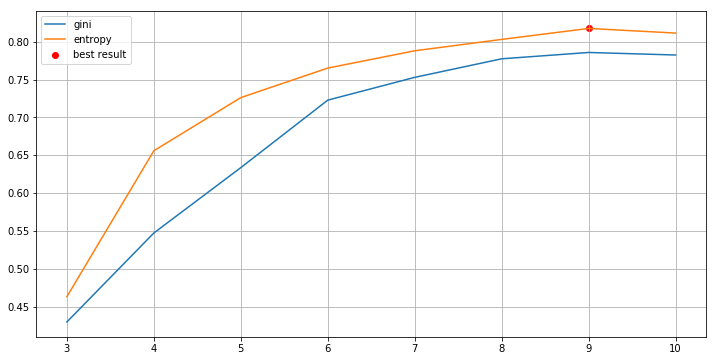

In [723]:
plt.figure(figsize=(12, 6))
for bounds in [(0, 11 -3), (11-3, 2 * (11-3))]:
    grid = [gscv.grid_scores_[i][0]["max_depth"] for i in range(*bounds)]
    accuracy = [gscv.grid_scores_[i][1] for i in range(*bounds)]
    criterion = gscv.grid_scores_[bounds[0]][0]["criterion"]
    plt.plot(grid, accuracy, label=criterion)
plt.scatter([gscv.best_params_["max_depth"]], [gscv.best_score_], color="red", label="best result")
plt.grid()
plt.legend()
plt.show()

Проанализируйте полученные графики. Чему равны найденные оптимальные значения параметров max_depth и criterion?

In [724]:
gscv.best_score_, gscv.best_params_

(0.8174735670562048, {'criterion': 'entropy', 'max_depth': 9})

**Комментарий:** Оптимальные значения - критерий: энтропия, максимальная глубина: 9. На конце графиков видно, что при глубине 10 качество падает при обоих критериях, т.е. наступает переобучение.

Используя найденные оптимальные значения max_depth и criterion, обучите решающее дерево на X_train, y_train и вычислите вероятности принадлежности к классам для X_test.

In [725]:
best_params = gscv.best_params_
best_params["predict_proba"] = True
dt = DecisionTree(**best_params)
dt.fit(X_train, y_train)
predicted_proba = dt.predict_proba(X_test)

In [726]:
predicted_proba.mean(axis=0)

array([0.09222846, 0.08174603, 0.08571429, 0.09722222, 0.13194444,
       0.13194444, 0.09563492, 0.1       , 0.08356519, 0.1       ])

Для полученной матрицы вычислите усредненные по всем объектам из `X_test` значения вероятностей принадлежности к классам.

Чему примерно равна максимальная вероятность в полученном векторе?

In [727]:
_, cnts = np.unique(y_test, return_counts=True)
cnts.astype(float) / cnts.sum()

array([0.09166667, 0.07777778, 0.09166667, 0.09444444, 0.12777778,
       0.13055556, 0.09722222, 0.09444444, 0.08333333, 0.11111111])

** Комментарий: ** Примерно равна вероятности самого большого класса в y_test например. Если посмотреть на распределение классов по train, то оно отличается как от предсказанного распределение, так и от реального распределения на test.

При этом реально и предсказанные распределения на test достаточно похожи, учитывая, что дерево предсказывает вероятности достаточно не точно.

In [728]:
_, cnts = np.unique(y_train, return_counts=True)  # TRAIN
cnts.astype(float) / cnts.sum()

array([0.10090466, 0.10716771, 0.10020877, 0.10368824, 0.09394572,
       0.09394572, 0.10160056, 0.10090466, 0.10020877, 0.09742519])

### Регрессия (10% баллов)

С помощью метода `load_boston` загрузите датасет `boston`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=42`. Попробуйте обучить неглубокие регрессионные деревья и убедитесь, что критерии `variance` и `mad_median` дают разные результаты.

In [729]:
boston = sklearn.datasets.load_boston()

In [730]:
boston.keys()

['data', 'feature_names', 'DESCR', 'target']

In [731]:
X = boston.data
y = boston.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [735]:
from sklearn.metrics import mean_squared_error
for criterion in ["variance", "mad_median"]:
    dt = DecisionTree(criterion=criterion, max_depth=7)
    dt.fit(X_train, y_train)
    mse = mean_squared_error(dt.predict(X_test), y_test)
    print("My DT. Criterion = {}, score = {}".format(criterion, mse))

My DT. Criterion = variance, score = 13.6052779482
My DT. Criterion = mad_median, score = 17.5320588235


In [736]:
from sklearn.tree import DecisionTreeRegressor
for  criterion in ["mse", "mae"]:
    dt = DecisionTreeRegressor(criterion=criterion, max_depth=7)
    dt.fit(X_train, y_train)
    mse = mean_squared_error(dt.predict(X_test), y_test)
    print("Sklearn DT : Criterion = {}, score = {}".format(criterion, mse))

Sklearn DT : Criterion = mse, score = 19.2656858261
Sklearn DT : Criterion = mae, score = 23.4284068627


С помощью 5-кратной кросс-валидации подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - `range(2, 9)`, а для `criterion` - {'variance', 'mad_median'}. Критерий качества `scoring`='neg_mean_squared_error'.

In [737]:
%%time
param_grid = {"max_depth":range(2, 9), "criterion":["variance", "mad_median"]}
model = DecisionTree()
print(type(model))
gscv = GridSearchCV(estimator=model, param_grid=param_grid, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
gscv.fit(X, y)
gscv

<class '__main__.DecisionTree'>
CPU times: user 1.48 s, sys: 56.1 ms, total: 1.54 s
Wall time: 14.3 s


Постройте графики средних значений критерия качества `neg_mean_squared_error` для критериев `variance` и `mad_median` в зависимости от `max_depth`.

In [738]:
import warnings
warnings.filterwarnings("ignore")
cv_scores = gscv.grid_scores_
cv_scores

[mean: -49.17279, std: 21.17937, params: {'criterion': 'variance', 'max_depth': 2},
 mean: -35.57665, std: 16.64283, params: {'criterion': 'variance', 'max_depth': 3},
 mean: -36.15029, std: 13.77848, params: {'criterion': 'variance', 'max_depth': 4},
 mean: -34.41885, std: 14.30843, params: {'criterion': 'variance', 'max_depth': 5},
 mean: -34.13441, std: 13.92997, params: {'criterion': 'variance', 'max_depth': 6},
 mean: -37.07961, std: 16.68416, params: {'criterion': 'variance', 'max_depth': 7},
 mean: -37.04727, std: 16.47816, params: {'criterion': 'variance', 'max_depth': 8},
 mean: -68.12958, std: 26.40691, params: {'criterion': 'mad_median', 'max_depth': 2},
 mean: -38.50503, std: 13.80421, params: {'criterion': 'mad_median', 'max_depth': 3},
 mean: -33.82721, std: 14.85207, params: {'criterion': 'mad_median', 'max_depth': 4},
 mean: -29.78289, std: 13.65234, params: {'criterion': 'mad_median', 'max_depth': 5},
 mean: -30.99236, std: 16.88565, params: {'criterion': 'mad_median',

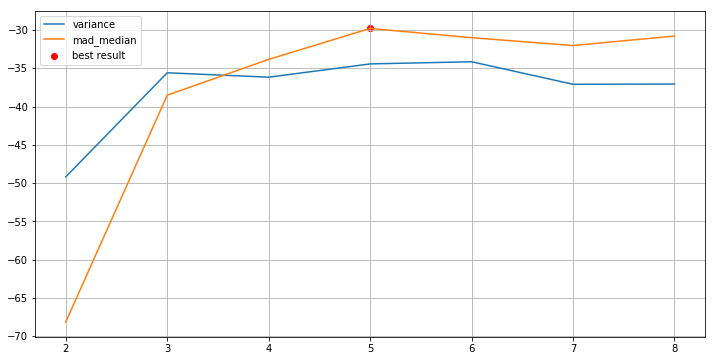

In [739]:
plt.figure(figsize=(12, 6))
l = len(gscv.grid_scores_) / 2

for bounds in [(0, l), (l, 2 * l)]:
    grid = [gscv.grid_scores_[i][0]["max_depth"] for i in range(*bounds)]
    accuracy = [gscv.grid_scores_[i][1] for i in range(*bounds)]
    criterion = gscv.grid_scores_[bounds[0]][0]["criterion"]
    plt.plot(grid, accuracy, label=criterion)
plt.scatter([gscv.best_params_["max_depth"]], [gscv.best_score_], color="red", label="best result")
plt.grid()
plt.legend()
plt.show()

Проанализируйте полученные графики. Чему равны найденные оптимальные значения параметров max_depth и criterion?

In [740]:
gscv.best_score_, gscv.best_params_

(-29.78289031620553, {'criterion': 'mad_median', 'max_depth': 5})

** Комментарий: ** Оптимальные параметры: критерий: mad_median, max_depth: 5. При этом можно заметить, что для второго критерия при той же максимальной глубине score отличается не сильно. Переобучения ещё очень заметно при глубине в 8, нужно больше деревьев для демонстрации переобучения. Ясно, что начиная с глубины 2 score растёт. Возможно, что дерево недообучено, построим график для более грубоких деревьев.

** Комментарий: ** Замена ответа в вершине со случайного наиболее встречающегося элемента на среднее на практике улучшает результат и необходимую глубину дерева.

_____________________


In [741]:
%%time
param_grid = {"max_depth":range(2, 19), "criterion":["variance", "mad_median"]}
model = DecisionTree()
print(type(model))
gscv = GridSearchCV(estimator=model, param_grid=param_grid, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
gscv.fit(X, y)
gscv

<class '__main__.DecisionTree'>
CPU times: user 1.63 s, sys: 80.2 ms, total: 1.71 s
Wall time: 56 s


In [742]:
import warnings
warnings.filterwarnings("ignore")
cv_scores = gscv.grid_scores_
cv_scores

[mean: -49.17279, std: 21.17937, params: {'criterion': 'variance', 'max_depth': 2},
 mean: -35.57665, std: 16.64283, params: {'criterion': 'variance', 'max_depth': 3},
 mean: -36.15029, std: 13.77848, params: {'criterion': 'variance', 'max_depth': 4},
 mean: -34.41885, std: 14.30843, params: {'criterion': 'variance', 'max_depth': 5},
 mean: -34.13441, std: 13.92997, params: {'criterion': 'variance', 'max_depth': 6},
 mean: -37.07961, std: 16.68416, params: {'criterion': 'variance', 'max_depth': 7},
 mean: -37.04727, std: 16.47816, params: {'criterion': 'variance', 'max_depth': 8},
 mean: -37.41030, std: 16.80892, params: {'criterion': 'variance', 'max_depth': 9},
 mean: -37.82555, std: 16.73905, params: {'criterion': 'variance', 'max_depth': 10},
 mean: -37.20653, std: 16.98181, params: {'criterion': 'variance', 'max_depth': 11},
 mean: -37.03955, std: 17.14717, params: {'criterion': 'variance', 'max_depth': 12},
 mean: -37.03906, std: 17.13729, params: {'criterion': 'variance', 'max_d

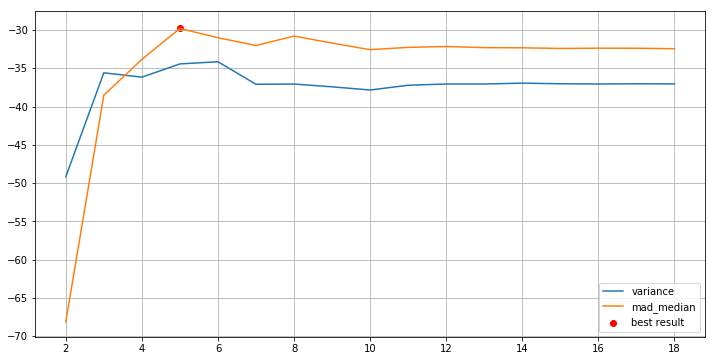

In [743]:
plt.figure(figsize=(12, 6))
l = len(gscv.grid_scores_) / 2

for bounds in [(0, l), (l, 2 * l)]:
    grid = [gscv.grid_scores_[i][0]["max_depth"] for i in range(*bounds)]
    accuracy = [gscv.grid_scores_[i][1] for i in range(*bounds)]
    criterion = gscv.grid_scores_[bounds[0]][0]["criterion"]
    plt.plot(grid, accuracy, label=criterion)
plt.scatter([gscv.best_params_["max_depth"]], [gscv.best_score_], color="red", label="best result")
plt.grid()
plt.legend()
plt.show()

Сделаем больше.

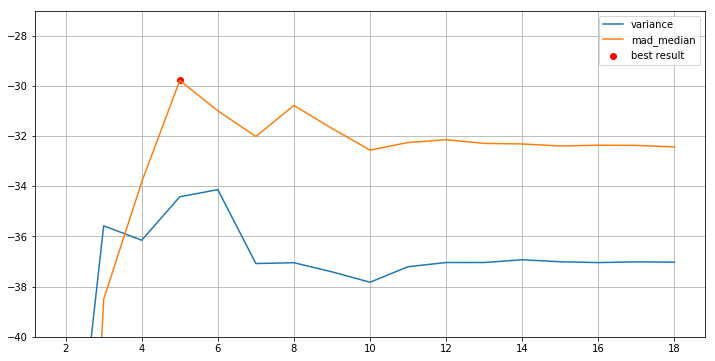

In [745]:
plt.figure(figsize=(12, 6))
l = len(gscv.grid_scores_) / 2

for bounds in [(0, l), (l, 2 * l)]:
    grid = [gscv.grid_scores_[i][0]["max_depth"] for i in range(*bounds)]
    accuracy = [gscv.grid_scores_[i][1] for i in range(*bounds)]
    criterion = gscv.grid_scores_[bounds[0]][0]["criterion"]
    plt.plot(grid, accuracy, label=criterion)
plt.scatter([gscv.best_params_["max_depth"]], [gscv.best_score_], color="red", label="best result")
plt.grid()
plt.legend()
plt.ylim((-40, -27))
plt.show()

** Комментарий: ** Видим намёк на переобучение.